<a href="https://colab.research.google.com/github/sakhnos/Paper4_Plasma/blob/master/Plasma_W()_non_normalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

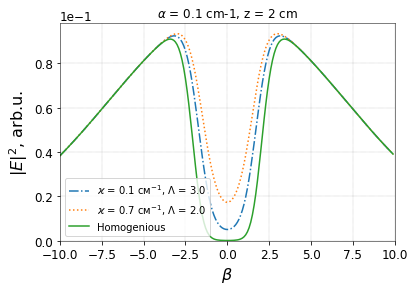

In [31]:
%reset -f 
import numpy as np
import math
from scipy.integrate import odeint
#from numpy import linspace, array
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter  

# With Lisitsa V.S. Dimensionless  quared Fourier transform for Gaussian pulse at different distance of propagation
# z and optical thickness L (Kappa in the figure).
c = 137
aB = 0.52 * 10 ** (-8) # Bohr's radius in cm
#N0 = 10 ** 20 #* (aB) ** 3
#E0 = 10 ** (-4)
#N0 = 1.82 * 10 ** 14  # my own profile 14

def N(z, kappa, z0, zb, N0):# concentration profile
    return N0 * (np.exp(-kappa * (z - z0)) + np.exp(kappa * (z - zb)))
    
def f(z, kappa, za, zb): 
    return (1 - np.exp(-kappa * (z - za)) * (1 + np.exp(kappa * (z - (zb-za)))))

def delta_wik(wik, T, M):
    #print( np.sqrt(T / M) * (wik / c) )
    return np.sqrt(T/M) * (wik / c)
    #print(np.sqrt(T / M) * (wik / c) * 27.2 * 1000)
    #return 1.25 * 10 ** (-3) / 27.2

def Doppler(w, wik, T, M):
    g = (np.exp( -((w - wik) ** 2)/(2 * (delta_wik(wik, T, M)) ** 2)  )) / (delta_wik(wik, T, M) * np.sqrt(2 * np.pi))
    #print(delta_wik(wik, T, M) * 27.2)
    return g

def sigma_abs(w, wik, f0, T, M):
    return (2 * np.pi ** 2 / c) * f0 * Doppler(w, wik, T, M) # Doppler() === G()

#beta = np.arange(-10, 10, 0.1)
#delta = 1.25 * 10 ** (-4) / 27.2 # width of line
#w0 = 10.199 / 27.2 # transition energy
#f0 = 0.416
#T = 10 / 27.2
#M = 1828

def sigma_abs_visualisation():
    sigma_abs_val = np.zeros(len(beta))
    for i in range(len(beta)):
         sigma_abs_val[i] = sigma_abs(w0 + delta * beta[i], w0, f0, T, M)  # wik - w0!!!!!!
    plt.plot(beta, sigma_abs_val)
    plt.show()

def Gmax(delta):
    return 1 / ((np.sqrt(2 * np.pi)) * delta)

def sigma_abs_max(delta, f0):
    return (2 * np.pi ** 2 * f0 * Gmax(delta)) / c

def Lkappa(delta, f0, N0, z, kappa, za, zb): # optical thickness L
    return sigma_abs_max(delta, f0) * (aB) ** 2 * N0 * f(z, kappa, za, zb)  / (2 * kappa)    # def f(z, kappa, za, zb): 
  
def E2FourL(beta, delta, alpha, kappa, w0, za, zb, z, E0, N0, f0, T, M, delta_small): # with optical thickness L
    g = E0 ** 2 * (np.pi/2) * (alpha ** 2 / delta ** 2) * np.exp(-(beta - delta_small) ** 2 * alpha ** 2 - \
        Lkappa(delta, f0, N0, z, kappa, za, zb) * Doppler(w0 + delta * beta, w0, T, M) / Gmax(delta) )   # Doppler() === G()
            #def f(z, kappa, za, zb): 
    return g

def W(beta, alpha, delta, z, kappa, za, zb, w0, f0, E0, T, M, N0, delta_small):
    a = (np.pi/4) * f0 * E0 ** 2 * alpha ** 2 / (w0 * delta)
    J = np.zeros(len(beta))
    for i in range(len(beta)):
       J[i] = Doppler(w0 + delta * beta[i], w0, T, M) * np.exp(-(beta[i] - delta_small) ** 2 * alpha ** 2 - Lkappa(delta, f0, N0, z, kappa, za, zb) *
                     Doppler(w0 + delta * beta[i], w0, T, M) / Gmax(delta))
    integral = a * np.trapz(J, beta)
    return integral
   
### Homogenious functions BEGIN ###  
def Lkappa_homo(delta, f0, N0, z, za): # optical thickness L for homogenious plasma
    return sigma_abs_max(delta, f0) * (aB) ** 2 * N0 * (z - za)
  
def E2FourL_homo(beta, delta, alpha, w0, za, z, E0, N0, f0, T, M, delta_small): # with optical thickness L
    g = E0 ** 2 * (np.pi/2) * (alpha ** 2 / delta ** 2) * np.exp(-(beta - delta_small) ** 2 * alpha ** 2 -
        Lkappa_homo(delta, f0, N0, z, za) * Doppler(w0 + delta * beta, w0, T, M) / Gmax(delta) )   # Doppler() === G()
    return g  
    
def W_homo(beta, alpha, delta, z, za, w0, f0, E0, T, M, N0, delta_small):
    a = (np.pi/4) * f0 * E0 ** 2 * alpha ** 2 / (w0 * delta)
    J = np.zeros(len(beta))
    for i in range(len(beta)):
       J[i] = Doppler(w0 + delta * beta[i], w0, T, M) * np.exp(-(beta[i] - delta_small) ** 2 * alpha ** 2 - Lkappa_homo(delta, f0, N0, z, za) *
                     Doppler(w0 + delta * beta[i], w0, T, M) / Gmax(delta))
    integral = a * np.trapz(J, beta)
    return integral  
  ### Homogenious functions END ###

def E2FourL_visualisation(): 
    beta = np.arange(-10, 10, 0.1)
    #delta = 1.25 * 10 ** (-3) / 27.2  # width of line
    E2F_1 = np.zeros(len(beta))
    E2F_2 = np.zeros(len(beta))
    E2F_homo = np.zeros(len(beta))
    alpha = 0.1
    kappa1 = 0.1
    kappa2 = 0.7
    za = 0
    zb = 100
    E0 = 10 ** (-4)
    N0 = 2 * 10 ** 14  # my own profile 14
    w0 = 10.199 / 27.2 # 10.199 alfa, 12.094 - beta
    f0 = 0.416
    T = 10 / 27.2      # Plasma's temperature 
    M = 1828
    z1 = 2
    delta_small = 0
    delta = delta_wik(w0, T, M)  # width of line

    for i in range(len(beta)):
        E2F_1[i] = E2FourL(beta[i], delta, alpha, kappa1, w0, za, zb, z1, E0, N0, f0, T, M, delta_small) # z
                   
    for i in range(len(beta)):
        E2F_2[i] = E2FourL(beta[i], delta, alpha, kappa2, w0, za, zb, z1, E0, N0, f0, T, M, delta_small) # z        
  
    for i in range(len(beta)): 
        E2F_homo[i] = E2FourL_homo(beta[i], delta, alpha, w0, za,     z1, E0, N0, f0, T, M, delta_small)
  
    #L1 = Lkappa(delta, f0, N0, z1, kappa, d)
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:white') # outer color
    plt.plot(beta, E2F_1,'-.')
    plt.plot(beta, E2F_2,':')
    plt.plot(beta, E2F_homo,'')
    ax = plt.gca()
    ax.set_facecolor((1.0, 1.0, 1.0))    # background color
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('0.0') 
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['top'].set_color('0.0') 
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['left'].set_color('0.0') 
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['right'].set_color('0.0') 
    ax.grid(b=True, which='major', axis='both', color = 'k', linestyle=':', linewidth=0.2)
    plt.xlabel(r'$\beta$',  {'color': 'k', 'fontsize': 16})
    plt.ylabel(r'$|E|^2$, arb.u.', {'color': 'k', 'fontsize': 16})
    plt.title(r'$\alpha$ = ' + str(alpha) + str(" cm-1, ") + "z = " + str(z1) + " cm")
    plt.ticklabel_format(style='sci', axis='y', scilimits=(2, 3), useOffset=False)
    plt.legend([r"$\varkappa$ = " + str(kappa1) + str(" см$^{-1}$, ") + r'$\Lambda$ = ' + str(round(Lkappa(delta, f0, N0, z1, kappa1, za, zb))),
                r"$\varkappa$ = " + str(kappa2) + str(" см$^{-1}$, ") + r'$\Lambda$ = ' + str(round(Lkappa(delta, f0, N0, z1, kappa2, za, zb))),
                r"Homogenious" ], loc='best', fontsize = 10)
    plt.ylim(0)
    plt.xlim(beta[0], beta[len(beta) - 1]+0.1)
    ax.yaxis.get_offset_text().set_fontsize(12) # size of the power in sci lim 
    for tick in ax.yaxis.get_major_ticks(): # size of numbers of Y-axia
        tick.label.set_fontsize(12) 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    plt.show()
    return

# def Nnh(N0, kappa, z, d): # Non-homogenious concentration. Z here is d/2 = 50 cm
#     return (2 * N0 * kappa * z) / f(z, kappa, d)

def concentration_visualisation():    
    zb = 100 
    za = 0
    N0 = 2 * 10 ** 14  # my own profile 14 
    z = np.arange(0, 100, 0.5)
    F1 = np.zeros(len(z))
    F2 = np.zeros(len(z))
    F3 = np.zeros(len(z)) 
    
    kappa1 = 0.1
    kappa2 = 0.2
    kappa3 = 0.5       # N(z, kappa, z0, d, N0):# concentration profile
        
    #N(z, kappa, za, zb, N0)
    for i in range(len(z)):
        F1[i] = N(z[i], kappa1, za, zb, N0)
        
    for i in range(len(z)):
        F2[i] = N(z[i], kappa2, za, zb, N0)
        
    for i in range(len(z)):
        F3[i] = N(z[i], kappa3, za, zb, N0)
    
    
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:white') # outer color
    plt.plot([za, zb], [N0, N0],'-.') 
    plt.plot(z, F1,'')
    plt.plot(z, F2,'--')
    plt.plot(z, F3,':')   
    ax = plt.gca()
    ax.set_facecolor((1.0, 1.0, 1.0))    # background color
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('0.0') 
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['top'].set_color('0.0') 
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['left'].set_color('0.0') 
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['right'].set_color('0.0') 
    ax.grid(b=True, which='major', axis='both', color = 'k', linestyle=':', linewidth=0.2)
    plt.xlabel(r'z, cm',  {'color': 'k', 'fontsize': 16})
    plt.ylabel(r'N(z), cm$^{-3}$', {'color': 'k', 'fontsize': 16})
 #  plt.title(r'$\alpha$ = ' + str(alpha) + str(" cm-1, ") + "z = " + str(z1) + " cm")
    plt.ticklabel_format(style='sci', axis='y', scilimits=(2, 3), useOffset=False)
    plt.legend([r"Homogenious", r"$\varkappa$ = " + str(kappa1) + str(" см$^{-1}$, "), r"$\varkappa$ = " + str(kappa2) + str(" см$^{-1}$, "),
                r"$\varkappa$ = " + str(kappa3) + str(" см$^{-1}$")], loc='best', fontsize = 13)
    plt.ylim(0)
    plt.xlim(z[0], z[len(z) - 1]+0.1)
    ax.yaxis.get_offset_text().set_fontsize(12) # size of the power in sci lim 
    for tick in ax.yaxis.get_major_ticks(): # size of numbers of Y-axia
        tick.label.set_fontsize(12) 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    plt.show()
    return
  

#concentration_visualisation() 
E2FourL_visualisation() # spectra visualisation

integration step = 0.013337779259753546


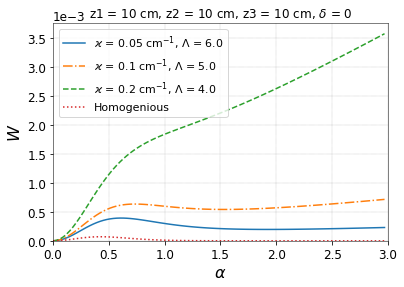

In [32]:
def Kappa(): # Optical path Kappa visualisation

    w0 = 10.199 / 27.2  # 10.199 alfa, 12.094 - beta
    T = 10 / 27.2
    M = 1828
    f0 = 0.416
    N0 = 1.82 * 10 ** 14  # my own profile 14
    d = 100
    z = np.linspace(0, d, 100)
    kappa = 0.9
    delta = delta_wik(w0, T, M)

    Kappa = np.zeros(len(z))
    for i in range(len(z)):
        Kappa[i] = Lkappa(delta, f0, N0, z[i], kappa, d)

    plt.plot(z, Kappa)
    plt.xlabel(r'z', {'color': 'k', 'fontsize': 16})
    plt.ylabel(r'$\Lambda$', {'color': 'k', 'fontsize': 16})
    plt.title("Optical path as a function of z at specific ... ")
    plt.show()

# Kappa()
# exit()

def W_visualisation():
    alpha = np.arange(0, 3, 0.03)    # 0.05
    beta = np.linspace(-20, 20, 3000)
    print(r"integration step = " + str(beta[1]-beta[0]))
    #kappa = 0.0000000001  # 0.01
    za = 0
    zb = 100
    E0 = 10 ** (-5)
    N0 = 10 ** 14  # my own profile 14
    w0 = 10.199 / 27.2   # 10.199 alfa, 12.094 - beta
    f0 = 0.416
    T = 10 / 27.2
    M = 1828
    
    z = 10
    zh = z # for homogenious case
    z1 = z
    z2 = z
    z3 = z
    delta = delta_wik(w0, T, M)
    delta_small = 0  # 3 or 5    frequency detuning
    #print(delta * 27.2 * 1000)
    #delta = 1.25 * 10 ** (-3) / 27.2  # width of line

    #print(Lkappa(delta, f0, N0, z1, kappa, d))

    kappa1 = 0.05  # 0.05
    kappa2 = 0.1   # 0.1
    kappa3 = 0.2   # 0.2

    W1 = np.zeros(len(alpha))
    W2 = np.zeros(len(alpha))
    W3 = np.zeros(len(alpha))
    Wh = np.zeros(len(alpha))
    
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:white') # outer color

    for i in range(len(alpha)): # def W(beta, alpha, delta, z, kappa,      za, zb, w0, f0, E0, T, M, N0, delta_small):
        W1[i] = W(beta, alpha[i], delta, z1, kappa1, za, zb, w0, f0, E0, T, M, N0, delta_small)
    plt.plot(alpha, W1, '')

    for i in range(len(alpha)): # W(beta, alpha, delta, z, kappa, d, w0, f0, E0, T, M, N0):
        W2[i] = W(beta, alpha[i], delta, z2, kappa2, za, zb, w0, f0, E0, T, M, N0, delta_small)
    plt.plot(alpha, W2, '-.')

    for i in range(len(alpha)): # W(beta, alpha, delta, z, kappa, d, w0, f0, E0, T, M, N0):
        W3[i] = W(beta, alpha[i], delta, z3, kappa3, za, zb, w0, f0, E0, T, M, N0, delta_small)
    plt.plot(alpha, W3, '--')
    
    for i in range(len(alpha)): # W_homo(beta, alpha[i], delta, z, d, w0, f0, E0, T, M, N0, delta_small):
        Wh[i] = W_homo(beta, alpha[i], delta, z, za, w0, f0, E0, T, M, N0, delta_small)
    plt.plot(alpha, Wh, ':')

    plt.xlabel(r'$\alpha$', {'color': 'k', 'fontsize': 16})
    plt.ylabel(r'$W$', {'color': 'k', 'fontsize': 16})
 ###   plt.title(r'$\Lambda$ = ' + str(round(Lkappa(delta, f0, N0, z1, kappa1, d))))

    plt.legend([r"$\varkappa$ = " + str(kappa1) + str(" cm$^{-1}$, ") + r'$\Lambda$ = ' + str(round(Lkappa(delta, f0, N0, z, kappa1, za, zb))),
                r"$\varkappa$ = " + str(kappa2) + str(" cm$^{-1}$, ") + r'$\Lambda$ = ' + str(round(Lkappa(delta, f0, N0, z, kappa2, za, zb))),
                r"$\varkappa$ = " + str(kappa3) + str(" cm$^{-1}$, ") + r'$\Lambda$ = ' + str(round(Lkappa(delta, f0, N0, z, kappa3, za, zb))),
               r"Homogenious"], loc='best', fontsize = 11)
    

    ax = plt.gca()
    # ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
    ax.set_facecolor((1.0, 1.0, 1.0))    # background color
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('0.0') 
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['top'].set_color('0.0') 
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['left'].set_color('0.0') 
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['right'].set_color('0.0') 
    ax.grid(b=True, which='major', axis='both', color = 'k', linestyle=':', linewidth=0.2)
    plt.xlim(0, alpha[-1] + alpha[1] - alpha[0], auto = True)    # + alpha[1] - alpha[0]
    #print(plt.xlim())
    for tick in ax.yaxis.get_major_ticks(): # size of numbers of Y-axia
        tick.label.set_fontsize(12) 
    for tick in ax.xaxis.get_major_ticks(): 
        tick.label.set_fontsize(12)  
        #ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
    plt.ylim(0)   # round(Lkappa(delta, f0, N0, z1, kappa1, d))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useOffset=False)
    ax.yaxis.get_offset_text().set_fontsize(12) # size of the power in sci lim 
    plt.title("z1 = " + str(z1) + " cm, " "z2 = " + str(z2) + " cm, " + "z3 = " + str(z3) + " cm, " +  "$\delta$ = " + str(delta_small))
    plt.show()

W_visualisation() 
